In [ ]:
!pip install tldextract
!pip install tweepy
!pip install spacy
!python -m spacy download en

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tldextract
from tqdm import tqdm
import tweepy
import spacy
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv("raw_data1.csv")
df.head()

,Patient Number,State Patient Number,Date Announced,Estimated Onset Date,Age Bracket,Gender,Detected City,Detected District,Detected State,State code,Current Status,Notes,Contracted from which Patient (Suspected),Nationality,Type of transmission,Status Change Date,Source_1,Source_2,Source_3,Backup Notes
0,1,KL-TS-P1,30/01/2020,NaN,20,F,Thrissur,Thrissur,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,14/02/2020,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan
1,2,KL-AL-P1,02/02/2020,NaN,NaN,NaN,Alappuzha,Alappuzha,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,14/02/2020,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan
2,3,KL-KS-P1,03/02/2020,NaN,NaN,NaN,Kasaragod,Kasaragod,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,14/02/2020,https://www.indiatoday.in/india/story/kerala-n...,https://twitter.com/ANI/status/122422148580539...,https://weather.com/en-IN/india/news/news/2020...,Student from Wuhan
3,4,DL-P1,02/03/2020,NaN,45,M,East Delhi (Mayur Vihar),East Delhi,Delhi,DL,Recovered,"Travelled from Austria, Italy",NaN,India,Imported,15/03/2020,https://www.indiatoday.in/india/story/not-a-ja...,https://economictimes.indiatimes.com/news/poli...,NaN,Travel history to Italy and Austria
4,5,TS-P1,02/03/2020,NaN,24,M,Hyderabad,Hyderabad,Telangana,TG,Recovered,"Travelled from Dubai to Bangalore on 20th Feb,...",NaN,India,Imported,02/03/2020,https://www.deccanherald.com/national/south/qu...,https://www.indiatoday.in/india/story/coronavi...,https://www.thehindu.com/news/national/coronav...,"Travel history to Dubai, Singapore contact"


In [9]:
def clean_source(source):
    original_source = source
    
    if isinstance(source, str):
        lower_source = source.lower().strip()
        if 'ap.gov.in' in source:
            lower_source = 'ap.gov.in' 
        elif 'State Health' in source:
            lower_source = 'State Bulletin'
        elif 'State Bulletin' in source:
            lower_source = 'State Bulletin'
        else: 
            tld = tldextract.extract(str(source))
            if tld.suffix:
                lower_source = tld.domain + '.' + tld.suffix
            else:
                lower_source = tld.domain
            
        return lower_source

In [10]:
df['Source_1_tld'] = df['Source_1'].apply(lambda x : clean_source(x))
df['Source_2_tld'] = df['Source_2'].apply(lambda x : clean_source(x))
df['Source_3_tld'] = df['Source_3'].apply(lambda x : clean_source(x))

# df.head()

In [11]:
# df.shape

In [12]:
df['Location'] = df[['Detected City', 'Detected District', 'Detected State', 'State code']].apply(lambda x: [str(x[0]).lower(), str(x[1]).lower(), str(x[2]).lower(), str(x[3]).lower()], axis=1)
df['Source'] = df[['Source_1','Source_2', 'Source_3']].apply(lambda x: [str(x[0]).lower(), str(x[1]).lower(), str(x[2]).lower()], axis=1)
df['Source_tld'] = df[['Source_1_tld','Source_2_tld', 'Source_3_tld']].apply(lambda x: [str(x[0]).lower(), str(x[1]).lower(), str(x[2]).lower()], axis=1)

In [13]:
domains = []
domains.extend(df['Source_1_tld'].values.tolist())
domains.extend(df['Source_2_tld'].values.tolist())
domains.extend(df['Source_3_tld'].values.tolist())
domains = [d for d in domains if isinstance(d, str) and d not in ('nan')]

In [14]:
np_domains, np_counts = np.unique(domains, return_counts=True)
freq_sources = {domain:count for domain, count in zip(np_domains, np_counts)}
# np_domains
#{k:v for k , v in sorted(freq_sources.items(), key=lambda x: x[1])}

# Histogram of the data

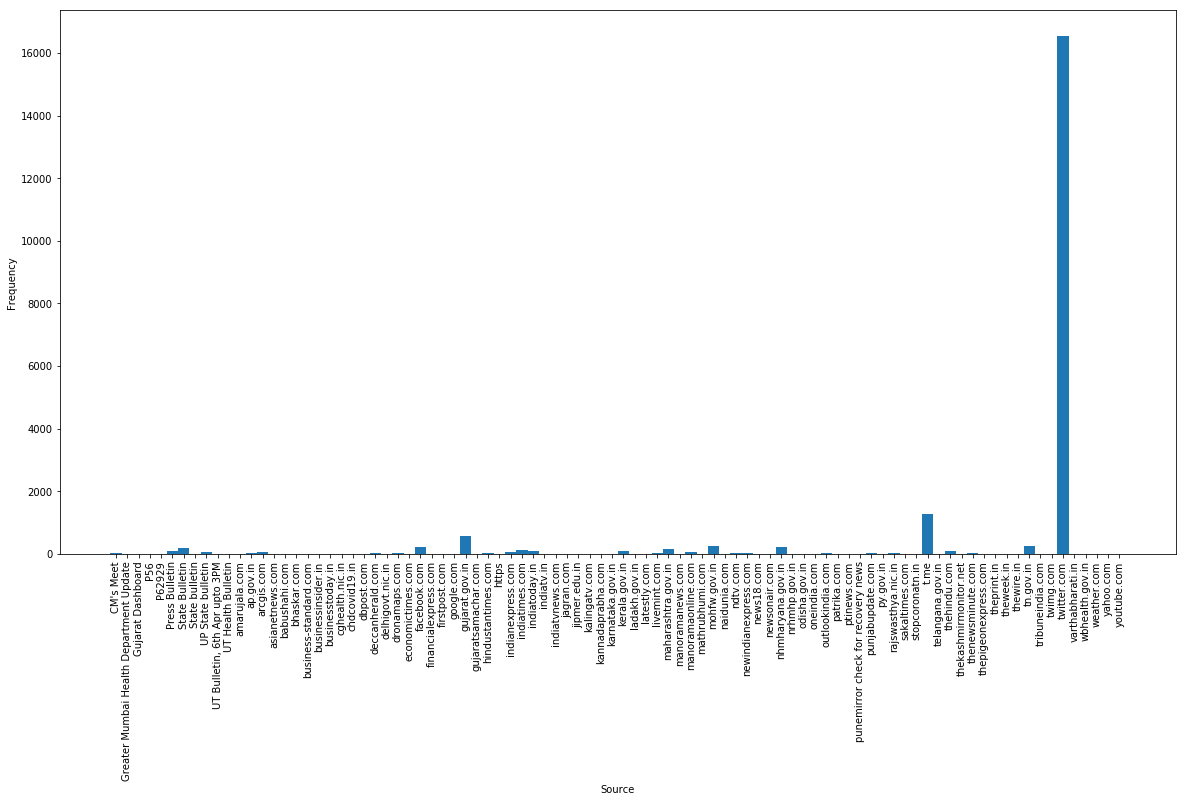

In [15]:
# the histogram of the data
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

ax = plt.subplot(111)
ax.set_xticklabels(np_domains,rotation=90)
plt.xlabel('Source')
plt.ylabel('Frequency')
ax.bar(np_domains, np_counts, width=1)
plt.savefig('a.png')





**Question** : Which is the major information source in the dataset in terms of OSM and other sources? Please put the quantitative numbers for both sources.

**Answer** :

| Category  | Source | Frequency |
| ------------- | ------------- | ------------- |
| OSM  | twitter.com | 16358 |
| Govt Website  | gujarat.gov.in | 574 |
| Instant Messaging  | t.me  | 1284 |

In [ ]:
import tweepy
import os
consumer_key = os.getenv('TWEEPY_CONSUMER_KEY', 'YOUR_CONSUMER_KEY')
consumer_secret = os.getenv('TWEEPY_CONSUMER_SECRET', 'YOUR_CONSUMER_SECRET')

access_token = os.getenv('TWEEPY_ACCESS_KEY', 'YOUR_ACCESS_KEY')
access_token_secret = os.getenv('TWEEPY_SECRET_KEY', 'YOUR_SECRET_KEY')

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

## Step 1: Extract Tweets

In [ ]:
import re


def twitter_process(cols):
  twitter_ids=list()
  # print(cols[0], cols[1], cols[2])
  if cols[0]=='twitter.com':
    id = re.search(r'[0-9]{19}', cols[3])
    if id is not None:
      twitter_ids.append(id.group(0))


  if  cols[1]=='twitter.com' :
    id=re.search(r'[0-9]{19}', cols[4])
    if id is not None:
      twitter_ids.append(id.group(0))

  if cols[2]=='twitter.com':
    id=re.search(r'[0-9]{19}', cols[5])
    if id is not None:
      twitter_ids.append(id.group(0))

  return twitter_ids 


existing_tweet_ids={}
error_ids=set()
def tweetInfo(columns):
  combined_tweet=''
  for id in columns:
    if id in existing_tweet_ids:
      combined_tweet+=existing_tweet_ids.get(id)+" "
    else:
      try:
        tweet = api.get_status(id)
        combined_tweet+=tweet.text+" "

        existing_tweet_ids[id]=tweet.text
      except:
        error_ids.add(id)

  return combined_tweet

df['twitter_ids'] = df[['Source_1_tld', 'Source_2_tld', 'Source_3_tld', 'Source_1', 'Source_2', 'Source_3']].apply(lambda cols: twitter_process(cols), axis=1)
df['tweet_content_combined']= df['twitter_ids'].apply(lambda x: tweetInfo(x)  )

In [ ]:
available_tweets = df[df['tweet_content_combined'].str.len() > 0]
# available_tweets.shape

In [ ]:
import joblib

joblib.dump(available_tweets, "tweets.pkl")

## Extract Location from Tweets

In [ ]:
## Load NLP Model
model = spacy.load('en')

In [ ]:
def get_location_from_text(text):
  locations = []
  nlp = model(text)
  for ent in nlp.ents: 
    if 'GPE' == ent.label_ or 'LOC' == ent.label_:
      locations.append(ent.text.lower()) 

  return locations

available_tweets['tweet_location']= available_tweets['tweet_content_combined'].apply(lambda x: get_location_from_text(x))

## Extract Tweets from Notes

In [ ]:
def get_location_from_notes(notes):
  notes, backup_text = str(notes[0]), str(notes[1])
  text = notes + '. ' + backup_text
  locations = []
  nlp = model(text)
  for ent in nlp.ents: 
    if 'GPE' == ent.label_ or 'LOC' == ent.label_:
      locations.append(ent.text.lower()) 

  return locations

available_tweets['notes_location']  = available_tweets[['Notes', 'Backup Notes']].apply(lambda x: get_location_from_notes(x), axis=1)


## Matched Percentage 

In [ ]:
def location_matches(compare_location, tweet_location):
  if compare_location is None:
    return 0
  if tweet_location is None:
    return 0

  compare_location = set(compare_location)
  tweet_location = set(tweet_location)

  return 1 if compare_location.intersection(tweet_location) != set() else 0

available_tweets['tweet_detected_matched'] = available_tweets[['Location', 'tweet_location']].apply(lambda x: location_matches(x[0], x[1]), axis=1)
available_tweets['tweet_notes_matched'] = available_tweets[['notes_location', 'tweet_location']].apply(lambda x: location_matches(x[0], x[1]), axis=1)


match_percent = (available_tweets['tweet_detected_matched'].sum() / available_tweets.shape[0]) * 100
print("Percentage of matched tweets and detected location = %f " % match_percent)

match_percent = (available_tweets['tweet_notes_matched'].sum() / available_tweets.shape[0]) * 100
print("Percentage of matched tweets and notes location = 1%f " % match_percent)